<a href="https://colab.research.google.com/github/adamrawashdeh/CMEpredict/blob/main/CMEpredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=========================================================================<br>
  (c) Copyright 2020<br>
  All rights reserved<br>
  Programs written by Hao Liu<br>
  Department of Computer Science<br>
  New Jersey Institute of Technology<br>
  University Heights, Newark, NJ 07102, USA<br>
<br>
  Permission to use, copy, modify, and distribute this<br>
  software and its documentation for any purpose and without<br>
  fee is hereby granted, provided that this copyright<br>
  notice appears in all copies. Programmer(s) makes no<br>
  representations about the suitability of this<br>
  software for any purpose.  It is provided "as is" without<br>
  express or implied warranty.<br>
=========================================================================

# **Packages**

In [ ]:
# !pip install shap
# !pip install yellowbrick
# !pip install eli5
# !pip install witwidget
# !pip install lime

# **Imports**

In [ ]:
import pandas as pd
from sklearn.utils import class_weight
from keras.models import *
from keras.layers import *
from keras.utils import plot_model
import numpy as np
import sys
import csv
import os
import warnings
from keras import regularizers
import shap
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeClassifier
from yellowbrick.classifier import PrecisionRecallCurve
import lime
from lime.lime_tabular import LimeTabularExplainer
import eli5
from witwidget.notebook.visualization import WitConfigBuilder, WitWidget

In [ ]:
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
try:
    import tensorflow as tf
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
except Exception as e:
    print('turn off loggins is not supported')

# **Functions**

In [ ]:
def load_data(datafile, series_len, start_feature, n_features, mask_value, type, time_window):
    df = pd.read_csv(datafile, header=None)
    df_values0 = df.values
    if type == 'gru':
        if time_window == 12:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 13, 7, 8, 15, 18, 21, 6, 9, 10, 17, 5, 16, 4, 12, 19, 20, 14]]  # 12   GRU
        elif time_window == 24:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 13, 15, 5, 20, 9, 21, 7, 8, 6, 17, 18, 10, 14, 4, 12, 16, 19]]  # 24   GRU
        elif time_window == 36:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 13, 20, 9, 21, 15, 8, 7, 4, 6, 14, 12, 17, 10, 18, 16, 19]]  # 36   GRU
        elif time_window == 48:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 13, 20, 9, 14, 8, 7, 21, 6, 4, 15, 12, 17, 16, 10, 18, 19]]  # 48   GRU
        elif time_window == 60:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 13, 20, 7, 15, 8, 14, 6, 21, 4, 9, 12, 10, 19, 18, 16, 17]]  # 60   GRU
    elif type == 'lstm':
        if time_window == 12:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 13, 20, 7, 15, 8, 21, 6, 18, 5, 10, 9, 17, 16, 19, 12, 14, 4]]  # 12   LSTM
        elif time_window == 24:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 20, 11, 13, 9, 15, 14, 8, 7, 5, 21, 6, 17, 18, 10, 12, 16, 4, 19]]  # 24   LSTM
        elif time_window == 36:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 20, 13, 5, 14, 8, 15, 7, 9, 21, 6, 4, 12, 17, 18, 10, 16, 19]]  # 36   LSTM
        elif time_window == 48:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 20, 13, 9, 14, 7, 15, 8, 6, 4, 21, 12, 17, 18, 16, 10, 19]]  # 48   LSTM
        elif time_window == 60:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 13, 20, 7, 15, 8, 14, 6, 21, 4, 9, 12, 10, 19, 18, 16, 17]]  # 60   LSTM
    X = []
    y = []
    tmp = []
    for k in range(start_feature, start_feature + n_features):
        tmp.append(mask_value)
    n_neg = 0
    n_pos = 0
    for idx in range(0, len(df_values)):
        each_series_data = []
        row = df_values[idx]
        label = row[0]
        if label == 'padding':
            continue
        has_zero_record = False
        # if one of the physical feature values is missing, then discard it.
        for k in range(start_feature, start_feature + n_features):
            if float(row[k]) == 0.0:
                has_zero_record = True
                break
        if has_zero_record is False:
            cur_harp_num = int(row[3])
            each_series_data.append(row[start_feature:start_feature + n_features].tolist())
            itr_idx = idx - 1
            while itr_idx >= 0 and len(each_series_data) < series_len:
                prev_row = df_values[itr_idx]
                prev_harp_num = int(prev_row[3])
                if prev_harp_num != cur_harp_num:
                    break
                has_zero_record_tmp = False
                for k in range(start_feature, start_feature + n_features):
                    if float(prev_row[k]) == 0.0:
                        has_zero_record_tmp = True
                        break
                if float(prev_row[-5]) >= 3500 or float(prev_row[-4]) >= 65536 or \
                        abs(float(prev_row[-1]) - float(prev_row[-2])) > 70:
                    has_zero_record_tmp = True
                if len(each_series_data) < series_len and has_zero_record_tmp is True:
                    each_series_data.insert(0, tmp)
                if len(each_series_data) < series_len and has_zero_record_tmp is False:
                    each_series_data.insert(0, prev_row[start_feature:start_feature + n_features].tolist())
                itr_idx -= 1
            while len(each_series_data) > 0 and len(each_series_data) < series_len:
                each_series_data.insert(0, tmp)
            if (label == 'N' or label == 'P') and len(each_series_data) > 0:
                X.append(np.array(each_series_data).reshape(series_len, n_features).tolist())
                if label == 'N':
                    y.append(0)
                    n_neg += 1
                elif label == 'P':
                    y.append(1)
                    n_pos += 1
    X_arr = np.array(X)
    y_arr = np.array(y)
    nb = n_neg + n_pos
    return X_arr, y_arr, nb

In [ ]:
def attention_3d_block(hidden_states, series_len):
    hidden_size = int(hidden_states.shape[2])
    hidden_states_t = Permute((2, 1), name='attention_input_t')(hidden_states)
    hidden_states_t = Reshape((hidden_size, series_len), name='attention_input_reshape')(hidden_states_t)
    score_first_part = Dense(series_len, use_bias=False, name='attention_score_vec')(hidden_states_t)
    score_first_part_t = Permute((2, 1), name='attention_score_vec_t')(score_first_part)
    h_t = Lambda(lambda x: x[:, :, -1], output_shape=(hidden_size, 1), name='last_hidden_state')(hidden_states_t)
    score = dot([score_first_part_t, h_t], [2, 1], name='attention_score')
    attention_weights = Activation('softmax', name='attention_weight')(score)
    context_vector = dot([hidden_states_t, attention_weights], [2, 1], name='context_vector')
    context_vector = Reshape((hidden_size,))(context_vector)
    h_t = Reshape((hidden_size,))(h_t)
    pre_activation = concatenate([context_vector, h_t], name='attention_output')
    attention_vector = Dense(hidden_size, use_bias=False, activation='tanh', name='attention_vector')(pre_activation)
    return attention_vector

In [ ]:
def lstm(n_features, series_len):
    inputs = Input(shape=(series_len, n_features,))
    lstm_out = LSTM(10, return_sequences=True, dropout=0.5, recurrent_dropout=0.3)(inputs)
    attention_mul = attention_3d_block(lstm_out, series_len)
    layer1 = Dense(100, activation='relu')(attention_mul)
    layer1 = Dropout(0.25)(layer1)
    output = Dense(1, activation='sigmoid', activity_regularizer=regularizers.l2(0.0001))(layer1)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [ ]:
def gru(n_features, series_len):
    inputs = Input(shape=(series_len, n_features,))
    lstm_out = GRU(10, return_sequences=True, dropout=0.5, recurrent_dropout=0.3)(inputs)
    attention_mul = attention_3d_block(lstm_out, series_len)
    layer1 = Dense(100, activation='relu')(attention_mul)
    layer1 = Dropout(0.25)(layer1)
    output = Dense(1, activation='sigmoid', activity_regularizer=regularizers.l2(0.0001))(layer1)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [ ]:
def output_result(test_data_file, result_file, type, time_window, start_feature, n_features, thresh):
    df = pd.read_csv(test_data_file, header=None)
    df_values0 = df.values
    if type == 'gru':
        if time_window == 12:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 13, 7, 8, 15, 18, 21, 6, 9, 10, 17, 5, 16, 4, 12, 19, 20, 14]]  # 12   GRU
        elif time_window == 24:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 13, 15, 5, 20, 9, 21, 7, 8, 6, 17, 18, 10, 14, 4, 12, 16, 19]]  # 24   GRU
        elif time_window == 36:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 13, 20, 9, 21, 15, 8, 7, 4, 6, 14, 12, 17, 10, 18, 16, 19]]  # 36   GRU
        elif time_window == 48:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 13, 20, 9, 14, 8, 7, 21, 6, 4, 15, 12, 17, 16, 10, 18, 19]]  # 48   GRU
        elif time_window == 60:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 13, 20, 7, 15, 8, 14, 6, 21, 4, 9, 12, 10, 19, 18, 16, 17]]  # 60   GRU
    elif type == 'lstm':
        if time_window == 12:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 13, 20, 7, 15, 8, 21, 6, 18, 5, 10, 9, 17, 16, 19, 12, 14, 4]]  # 12   LSTM
        elif time_window == 24:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 20, 11, 13, 9, 15, 14, 8, 7, 5, 21, 6, 17, 18, 10, 12, 16, 4, 19]]  # 24   LSTM
        elif time_window == 36:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 20, 13, 5, 14, 8, 15, 7, 9, 21, 6, 4, 12, 17, 18, 10, 16, 19]]  # 36   LSTM
        elif time_window == 48:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 20, 13, 9, 14, 7, 15, 8, 6, 4, 21, 12, 17, 18, 16, 10, 19]]  # 48   LSTM
        elif time_window == 60:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 13, 20, 7, 15, 8, 14, 6, 21, 4, 9, 12, 10, 19, 18, 16, 17]]  # 60   LSTM
    with open(result_file, 'w', encoding='UTF-8') as result_csv:
        w = csv.writer(result_csv)
        w.writerow(['Predicted Label', 'Label', 'Timestamp', 'NOAA AR NUM', 'HARP NUM',
                      'TOTUSJH', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP', 'USFLUX', 'AREA_ACR',
                      'MEANPOT', 'R_VALUE', 'SHRGT45', 'MEANGAM', 'MEANJZH', 'MEANGBT', 'MEANGBZ',
                      'MEANJZD', 'MEANGBH', 'MEANSHR', 'MEANALP'])
        idx = 0
        for i in range(len(df_values)):
            line = df_values[i].tolist()
            if line[0] == 'padding' or float(line[-5]) >= 3500 or float(line[-4]) >= 65536 \
                    or abs(float(line[-1]) - float(line[-2])) > 70:
                continue
            has_zero_record = False
            # if one of the physical feature values is missing, then discard it.
            for k in range(start_feature, start_feature + n_features):
                if float(line[k]) == 0.0:
                    has_zero_record = True
                    break
            if has_zero_record:
                continue
            if prob[idx] >= thresh:
                line.insert(0, 'P')
            else:
                line.insert(0, 'N')
            idx += 1
            w.writerow(line)

In [ ]:
def get_n_features_thresh(type, time_window):
    n_features = 0
    thresh = 0
    if type == 'gru':
        if time_window == 12:
            n_features = 16
            thresh = 0.45
        elif time_window == 24:
            n_features = 12
            thresh = 0.4
        elif time_window == 36:
            n_features = 9
            thresh = 0.45
        elif time_window == 48:
            n_features = 14
            thresh = 0.45
        elif time_window == 60:
            n_features = 5
            thresh = 0.5
    elif type == 'lstm':
        if time_window == 12:
            n_features = 15
            thresh = 0.4
        elif time_window == 24:
            n_features = 12
            thresh = 0.45
        elif time_window == 36:
            n_features = 8
            thresh = 0.45
        elif time_window == 48:
            n_features = 15
            thresh = 0.45
        elif time_window == 60:
            n_features = 6
            thresh = 0.5
    return n_features, thresh

# **Main**

In [ ]:
if __name__ == '__main__':
    type = 'lstm'
    time_window = 12
    train_again = 0
    train_data_file = './normalized_training_' + str(time_window) + '.csv'
    test_data_file = './normalized_testing_' + str(time_window) + '.csv'
    result_file = './' + type + '-' + str(time_window) + '-output.csv'
    model_file = './' + type + '-' + str(time_window) + '-model.h5'
    start_feature = 4
    n_features, thresh = get_n_features_thresh(type, time_window)
    mask_value = 0
    series_len = 20
    epochs = 20
    batch_size = 256
    nclass = 2

# **Train**

In [ ]:
    # Train
    print('loading training data...')
    X_train, y_train, nb_train = load_data(datafile='/content/sample_data/normalized_testing_12.csv',
                                            series_len=series_len,
                                            start_feature=start_feature,
                                            n_features=n_features,
                                            mask_value=mask_value,
                                            type=type,
                                            time_window=time_window)
    class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                    classes=np.unique(y_train),
                                                    y=y_train)
    class_weight_ = {0: class_weights[0], 1: class_weights[1]}
    print('done loading training data...')
    if type == 'gru':
        model = gru(n_features, series_len)
    elif type == 'lstm':
        model = lstm(n_features, series_len)
    print('training the model, wait until it is finished...')
    model.compile(loss='binary_crossentropy',
                    optimizer='RMSprop',
                    metrics=['accuracy'])
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=False,
                        shuffle=True,
                        class_weight=class_weight_)
    print('finished...')
    model.save(model_file)

loading training data...
done loading training data...
training the model, wait until it is finished...
finished...


# **Yellowbrick**

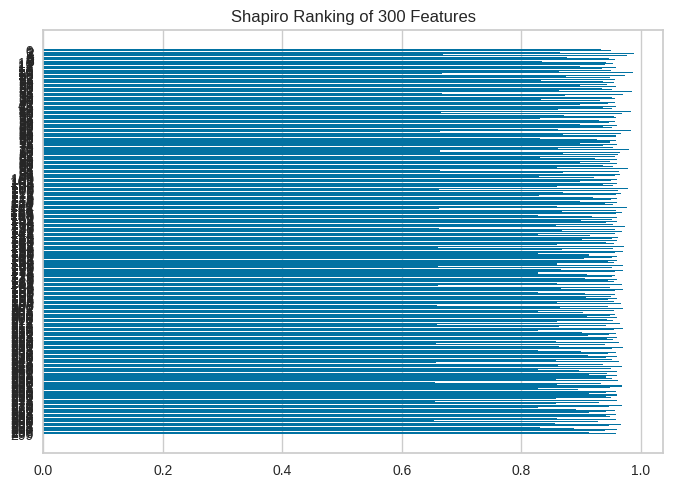

<Axes: title={'center': 'Shapiro Ranking of 300 Features'}>

In [ ]:
    # Rank
    from yellowbrick.features import Rank1D

    visualizer = Rank1D(algorithm='shapiro')
    X_train_flattened = X_train.reshape(X_train.shape[0], -1)

    # visualizer.fit(X_train[0], y_train)
    # visualizer.transform(X_train[0])

    visualizer.fit(X_train_flattened, y_train)
    visualizer.transform(X_train_flattened)

    visualizer.show()

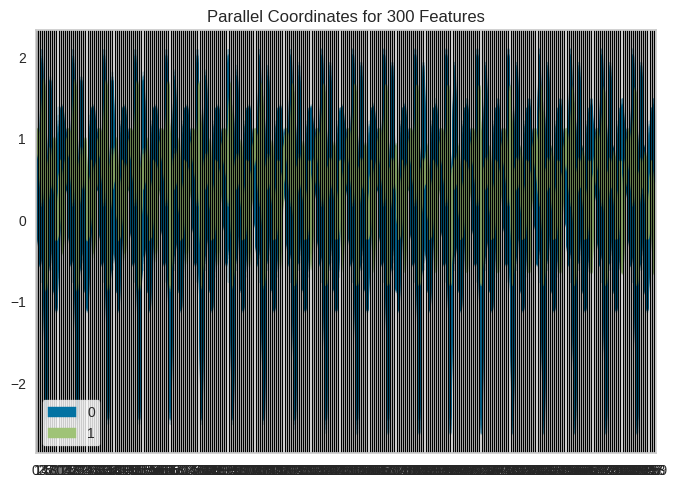

<Axes: title={'center': 'Parallel Coordinates for 300 Features'}>

In [ ]:
    # Parallel Coordinates
    from yellowbrick.features import ParallelCoordinates

    feature_indices = list(range(X_train.shape[0]))

    X_train_flattened = X_train.reshape(X_train.shape[0], -1)

    # visualizer = ParallelCoordinates(features=feature_indices[0:15], shuffle=True)
    visualizer = ParallelCoordinates(shuffle=True)

    visualizer.fit_transform(X_train_flattened, y_train)
    visualizer.show()

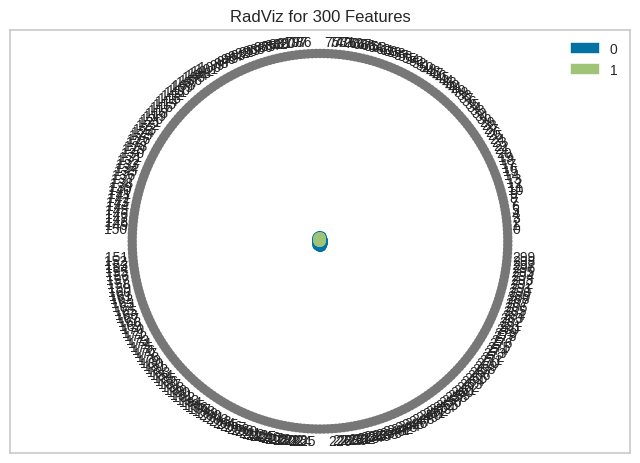

<Axes: title={'center': 'RadViz for 300 Features'}>

In [ ]:
    # Radial Visualization
    from yellowbrick.features import RadViz

    feature_indices = list(range(X_train.shape[1]))

    X_train_flattened = X_train.reshape(X_train.shape[0], -1)

    # visualizer = RadViz(features=feature_indices[0:15])
    visualizer = RadViz()

    # visualizer.fit(X_train[0], y_train[0:20])
    visualizer.fit(X_train_flattened, y_train)

    visualizer.show()

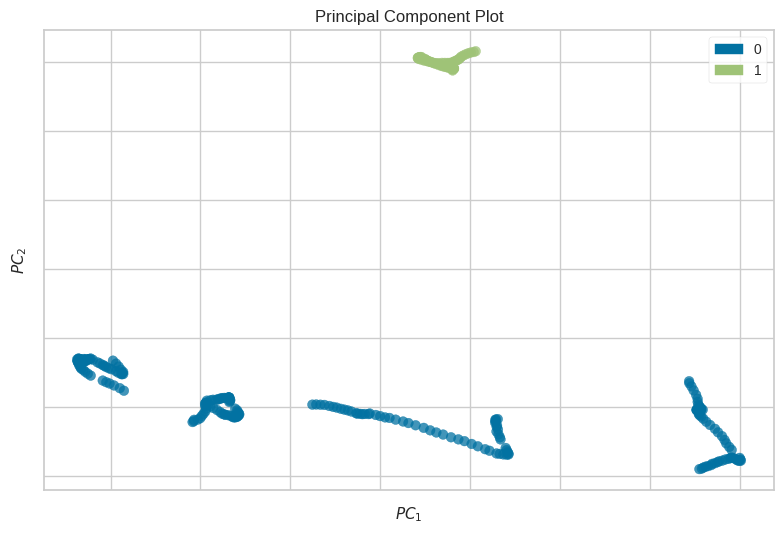

<Axes: title={'center': 'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [ ]:
    # PCA Projection
    from yellowbrick.features import PCA

    X_train_flattened = X_train.reshape(X_train.shape[0], -1)

    visualizer = PCA(scale=True, n_components=15)

    # visualizer.fit_transform(X_train[0], y_train[0:15])
    visualizer.fit_transform(X_train_flattened, y_train)

    visualizer.show()

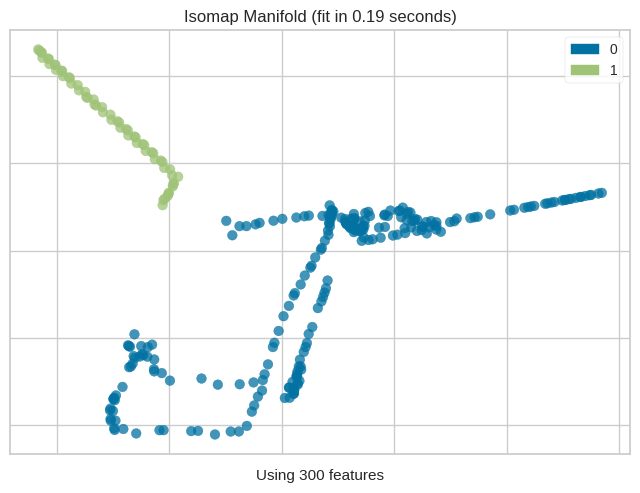

<Axes: title={'center': 'Isomap Manifold (fit in 0.19 seconds)'}, xlabel='Using 300 features'>

In [ ]:
    from yellowbrick.features import Manifold

    feature_indices = list(range(X_train.shape[1]))
    X_train_flattened = X_train.reshape(X_train.shape[0], -1)

    viz = Manifold(manifold="isomap")

    viz.fit_transform(X_train_flattened, y_train)
    viz.show()

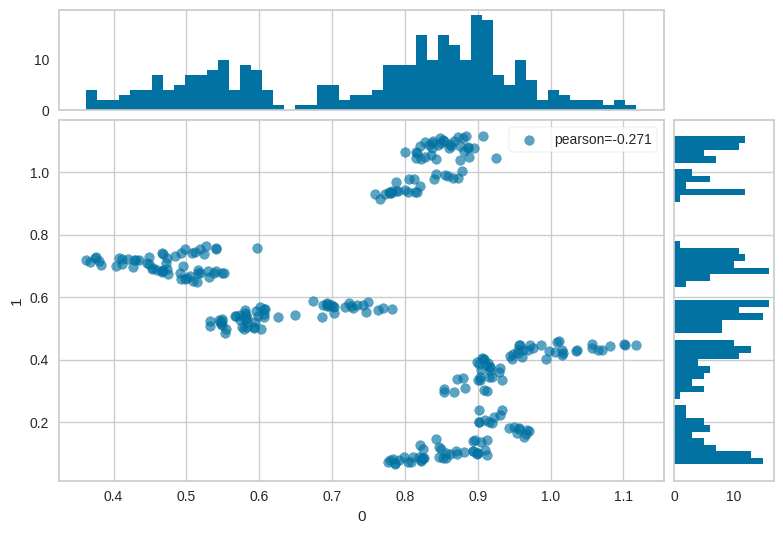

<Axes: xlabel='0', ylabel='1'>

In [ ]:
    # Joint Plot
    from yellowbrick.features import JointPlotVisualizer

    X_train_flattened = X_train.reshape(X_train.shape[0], -1)

    visualizer = JointPlotVisualizer(columns=[0,1])

    # visualizer.fit_transform(X_train[0], y_train)
    visualizer.fit_transform(X_train_flattened, y_train)

    visualizer.show()

# **Test**

In [ ]:
    # Test
    print('loading testing data')
    X_test, y_test, nb_test = load_data(datafile='/content/sample_data/normalized_testing_12.csv',
                                        series_len=series_len,
                                        start_feature=start_feature,
                                        n_features=n_features,
                                        mask_value=mask_value,
                                        type=type,
                                        time_window=time_window)
    print('done loading testing data...')
    print('predicting testing data...')
    prob = model.predict(X_test,
                         batch_size=batch_size,
                         verbose=False,
                         steps=None)
    print('done predicting...')

loading testing data
done loading testing data...
predicting testing data...
done predicting...


# **What-If Tool (WIT)**

In [ ]:
    X_test_flat = X_test.reshape((X_test.shape[0], -1))
    feature_indices = np.arange(X_test_flat.shape[1])

    config_builder = WitConfigBuilder(X_test_flat).set_estimator_and_feature_spec(model, feature_indices)
    X_test_list = X_test_flat.tolist()
    WitWidget(config_builder.set_examples(X_test_list), height=800)

# **Explain Like I'm 5 (ELI5)**

In [ ]:
    eli5.show_weights(feature_indices)

In [ ]:
    # sklearn-crfsuite
    eli5.explain_weights(X_train[0])

Explanation(estimator='array([[ 4.98600006e-01,  7.54800022e-01,  1.78599998e-01,\n         6.13099992e-01, -2.63300002e-01, -1.34210002e+00,\n         3.93999994e-01,  6.59099996e-01,  2.79599994e-01,\n        -2.58000009e-02, -6.28899992e-01,  1.37619996e+00,\n         3.94100010e-01,  1.22119999e+00,  6.77999973e-01],\n       [ 5.26700020e-01,  7.63700008e-01,  2.13499993e-01,\n         6.52400017e-01, -2.61999995e-01, -1.27869999e+00,\n         4.22899991e-01,  6.22699976e-01,  3.84200007e-01,\n         1.00000005e-03, -6.15100026e-01,  1.27550006e+00,\n         3.92199993e-01,  1.17690003e+00,  6.72699988e-01],\n       [ 5.40000021e-01,  7.57200003e-01,  2.46800005e-01,\n         6.28300011e-01, -2.56099999e-01, -1.24679995e+00,\n         4.68300015e-01,  6.35200024e-01,  3.65200013e-01,\n         3.18000019e-02, -6.21599972e-01,  9.93799984e-01,\n         3.78500015e-01,  1.10060000e+00,  6.59300029e-01],\n       [ 5.40099978e-01,  7.54599988e-01,  2.77700007e-01,\n         6.11000001e-01, -2.52400011e-01, -1.21319997e+00,\n         4.83599991e-01,  6.23399973e-01,  3.37099999e-01,\n         4.52999994e-02, -6.19300008e-01,  8.82900000e-01,\n         3.65300000e-01,  1.07239997e+00,  6.57800019e-01],\n       [ 5.18499970e-01,  7.53000021e-01,  2.88700014e-01,\n         6.35900021e-01, -2.50600010e-01, -1.23179996e+00,\n         5.03499985e-01,  6.46899998e-01,  3.35700005e-01,\n         6.67999983e-02, -6.38199985e-01,  7.05500007e-01,\n         3.49299997e-01,  1.03939998e+00,  6.55200005e-01],\n       [ 5.11300027e-01,  7.46299982e-01,  3.05299997e-01,\n         5.93100011e-01, -2.48600006e-01, -1.20369995e+00,\n         5.21799982e-01,  6.08299971e-01,  3.72299999e-01,\n         8.87999982e-02, -6.25899971e-01,  7.75600016e-01,\n         3.49999994e-01,  1.03009999e+00,  6.60899997e-01],\n       [ 4.83799994e-01,  7.32100010e-01,  2.98599988e-01,\n         5.16799986e-01, -2.49500006e-01, -1.20790005e+00,\n         5.22199988e-01,  5.78800023e-01,  4.30599988e-01,\n         6.81999996e-02, -6.18499994e-01,  8.61500025e-01,\n         3.29499990e-01,  1.08000004e+00,  6.74499989e-01],\n       [ 4.72900003e-01,  7.25300014e-01,  2.54799992e-01,\n         6.41200006e-01, -2.45499998e-01, -1.30669999e+00,\n         4.78700012e-01,  6.50600016e-01,  4.46700007e-01,\n         3.73999998e-02, -6.54200017e-01,  6.39999986e-01,\n         3.47200006e-01,  1.16390002e+00,  6.90999985e-01],\n       [ 4.31100011e-01,  7.20799983e-01,  2.78100014e-01,\n         6.10499978e-01, -2.43399993e-01, -1.32509995e+00,\n         5.04100025e-01,  6.37099981e-01,  4.44599986e-01,\n         3.86000015e-02, -6.55099988e-01,  9.08500016e-01,\n         3.19700003e-01,  1.16349995e+00,  7.00900018e-01],\n       [ 4.07299995e-01,  7.24799991e-01,  2.75099993e-01,\n         5.94099998e-01, -2.45900005e-01, -1.33580005e+00,\n         4.99799997e-01,  6.34299994e-01,  4.24899995e-01,\n         2.77999993e-02, -6.53199971e-01,  5.96099973e-01,\n         3.10999990e-01,  1.16369998e+00,  7.03400016e-01],\n       [ 3.75800014e-01,  7.29799986e-01,  2.66499996e-01,\n         7.23100007e-01, -2.41799995e-01, -1.43040001e+00,\n         5.07900000e-01,  6.96300030e-01,  4.15800005e-01,\n         4.50000018e-02, -6.89700007e-01,  6.54600024e-01,\n         2.88399994e-01,  1.17949998e+00,  7.09699988e-01],\n       [ 3.74199986e-01,  7.27100015e-01,  2.67399997e-01,\n         6.97899997e-01, -2.38100007e-01, -1.45099998e+00,\n         5.00599980e-01,  6.93199992e-01,  4.12999988e-01,\n         3.31999995e-02, -6.80299997e-01,  3.40700001e-01,\n         2.97899991e-01,  1.22449994e+00,  7.17400014e-01],\n       [ 3.62399995e-01,  7.19600022e-01,  2.69400001e-01,\n         8.30900013e-01, -2.39700004e-01, -1.60399997e+00,\n         4.92399991e-01,  8.25999975e-01,  3.93299997e-01,\n         4.14999984e-02, -7.42600024e-01,  5.83599985e-01,\n         2.95899987e-01,  1.20019996e+00,  7.14399993e-01],\n       [ 3.67799997e-01,  7.13299990e-01,  2.43799999e-01,\n    

# **Local Interpretable Model-Agnostic Explanations (LIME)**

In [ ]:
    # Flatten the training data correctly
    X_train_flattened = X_train.reshape((X_train.shape[0], -1))
    print("Shape of X_train_flattened:", X_train_flattened.shape)

    # Generate feature names for the flattened data
    num_features = X_train_flattened.shape[1]  # This should be 300
    feature_names = [f'feature_{i}' for i in range(num_features)]
    print("Feature names length:", len(feature_names))

    # Initialize the LimeTabularExplainer with the flattened training data
    explainer = lime.lime_tabular.LimeTabularExplainer(X_train_flattened, feature_names=feature_names, verbose=True, mode='regression')

    # Select and flatten a single instance from the test set
    instance = X_test[0].reshape(-1)  # Ensure this is a flattened 1D array
    print("Shape of flattened instance:", instance.shape)

    # Define custom prediction function with debug prints
    def model_predict_reshaped(instances):
        print(f"Shape before reshaping: {instances.shape}")
        # Reshape the instances back to the original 3D shape expected by the LSTM model
        num_instances = instances.shape[0]
        instances_reshaped = instances.reshape(num_instances, 20, 15)
        print(f"Shape after reshaping: {instances_reshaped.shape}")
        return model.predict(instances_reshaped)

    # Explain the instance using the custom prediction function
    exp = explainer.explain_instance(instance, model_predict_reshaped, num_features=20)

Shape of X_train_flattened: (291, 300)
Feature names length: 300
Shape of flattened instance: (300,)
Shape before reshaping: (5000, 300)
Shape after reshaping: (5000, 20, 15)
157/157 [==============================] - 1s 5ms/step
Intercept 0.13406227264047071
Prediction_local [0.11949241]
Right: 0.1294117


In [ ]:
    exp.show_in_notebook(show_table=True)

In [ ]:
    exp.as_list()

[('feature_298 > 1.17', -0.003933892857715142),
 ('feature_253 > 1.16', -0.0024234780410337365),
 ('feature_287 > 0.16', 0.002362612524883465),
 ('feature_268 > 1.16', -0.0022945249545314513),
 ('feature_163 > 1.15', -0.0021645445839441426),
 ('feature_223 > 1.15', -0.00206588576234031),
 ('feature_291 > 0.33', 0.002040427956667521),
 ('feature_238 > 1.16', -0.002021950034335071),
 ('feature_178 > 1.15', -0.0020160240285630113),
 ('feature_283 > 1.17', -0.0019378300292476416),
 ('feature_193 > 1.14', -0.0018206489235484738),
 ('feature_208 > 1.15', -0.0017683980895710548),
 ('feature_118 > 1.13', -0.0016421362870110263),
 ('feature_152 > 0.18', 0.0016297420266641926),
 ('feature_167 > 0.17', 0.0015853256985807575),
 ('feature_257 > 0.16', 0.0015680025153852336),
 ('feature_242 > 0.16', 0.00151254168737322),
 ('feature_227 > 0.16', 0.0014505174954574714),
 ('feature_148 > 1.14', -0.0013215307608730072),
 ('feature_133 > 1.14', -0.0013081849110325543)]

In [ ]:
    # Flatten the training data correctly
    X_train_flattened = X_train.reshape((X_train.shape[0], -1))
    print("Shape of X_train_flattened:", X_train_flattened.shape)

    # Generate feature names for the flattened data
    num_features = X_train_flattened.shape[1]  # This should be 300
    feature_names = [f'feature_{i}' for i in range(num_features)]
    print("Feature names length:", len(feature_names))

    # Initialize the LimeTabularExplainer with the flattened training data
    explainer = lime.lime_tabular.LimeTabularExplainer(X_train_flattened, feature_names=feature_names, verbose=True, mode='regression')

    # Select and flatten a single instance from the test set
    instance = X_test[0].reshape(-1)
    print("Shape of flattened instance:", instance.shape)

    # Define custom prediction function with debug prints
    def model_predict_reshaped(instances):
        print(f"Shape before reshaping: {instances.shape}")
        # Reshape the instances back to the original 3D shape expected by the LSTM model
        num_instances = instances.shape[0]
        instances_reshaped = instances.reshape(num_instances, 20, 15)
        print(f"Shape after reshaping: {instances_reshaped.shape}")
        return model.predict(instances_reshaped)

    # Explain the instance using the custom prediction function and print all features
    exp = explainer.explain_instance(instance, model_predict_reshaped, num_features=300)

Shape of X_train_flattened: (291, 300)
Feature names length: 300
Shape of flattened instance: (300,)
Shape before reshaping: (5000, 300)
Shape after reshaping: (5000, 20, 15)
157/157 [==============================] - 1s 5ms/step
Intercept 0.1285366980024285
Prediction_local [0.13546203]
Right: 0.1294117


In [ ]:
    exp.show_in_notebook(show_table=True)

In [ ]:
    exp.as_list()

[('feature_298 > 1.17', -0.0034537510500985864),
 ('feature_163 > 1.15', -0.002810003984952889),
 ('feature_253 > 1.16', -0.0027848694943695355),
 ('feature_283 > 1.17', -0.0025772385701380222),
 ('feature_268 > 1.16', -0.002576143946458412),
 ('feature_178 > 1.15', -0.0023999507882105195),
 ('feature_152 > 0.18', 0.0023787562508166917),
 ('feature_167 > 0.17', 0.0022754363940762417),
 ('feature_291 > 0.33', 0.0022142965244266433),
 ('feature_238 > 1.16', -0.002176196065769232),
 ('feature_287 > 0.16', 0.002154479345513132),
 ('feature_148 > 1.14', -0.002037123945705315),
 ('feature_133 > 1.14', -0.0019236453394334224),
 ('feature_208 > 1.15', -0.001907194434154061),
 ('feature_242 > 0.16', 0.0017380171700685754),
 ('feature_137 > 0.18', 0.0016552561103731582),
 ('feature_223 > 1.15', -0.001624643007546119),
 ('feature_257 > 0.16', 0.0016000639546521172),
 ('feature_193 > 1.14', -0.0015738777673761808),
 ('feature_227 > 0.16', 0.0013908641611842375),
 ('feature_118 > 1.13', -0.00137144

# **SHapley Additive exPlanations (SHAP)**

In [ ]:
    explainer = shap.GradientExplainer(model, X_train)
    shap_values = explainer(X_test)

10/10 [==============================] - 0s 11ms/step


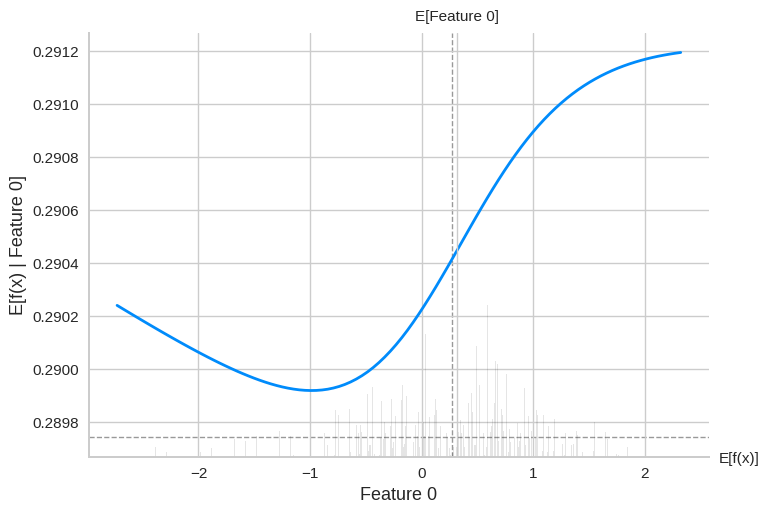

In [ ]:
    shap.partial_dependence_plot(
        0,
        model.predict,
        X_test,
        ice=False,
        model_expected_value=True,
        feature_expected_value=True,
    )

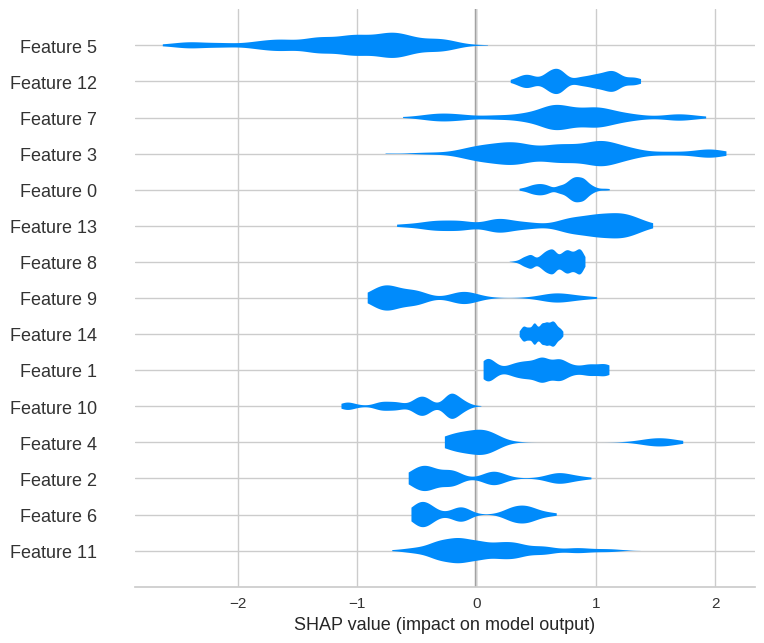

In [ ]:
    shap_values_reshaped = shap_values.data.reshape(-1, 15)
    shap.plots.violin(shap_values_reshaped)

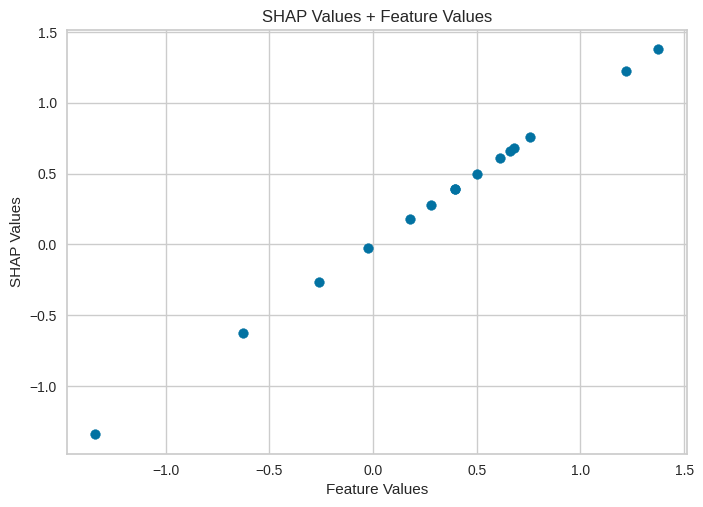

In [ ]:
    feature_index = 0
    feature_values = X_test[:, feature_index]

    plt.scatter(shap_values.data[0][0], feature_values[0], alpha=1)
    plt.xlabel('Feature Values')
    plt.ylabel('SHAP Values')
    plt.title('SHAP Values + Feature Values')
    plt.show()

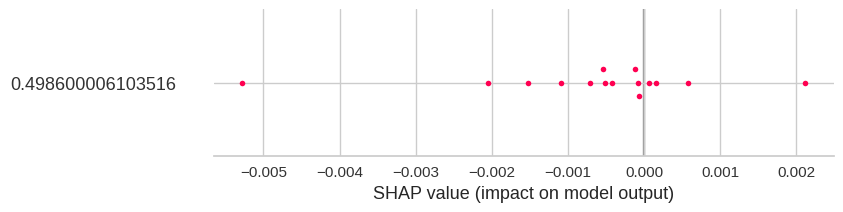

In [ ]:
    shap.plots.beeswarm(shap_values[0][0], color="shap_red")

# **Output**

In [ ]:
    print('writing prediction results into file...')
    output_result(test_data_file='/content/sample_data/normalized_testing_12.csv',
                  result_file=result_file,
                  type=type,
                  time_window=time_window,
                  start_feature=start_feature,
                  n_features=n_features,
                  thresh=thresh)
    print('done...')

writing prediction results into file...
done...
